In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load IRS csv
# df_2016 = pd.read_csv('https://www.irs.gov/pub/irs-soi/16zpallagi.csv')
# df_2012 = pd.read_csv("https://www.irs.gov/pub/irs-soi/12zpallagi.csv')
df_2016 = pd.read_csv("16zpallagi.csv")
df_2012 = pd.read_csv("12zpallagi.csv")

In [3]:
# filter based on highest income bracket
df_2016 = df_2016.loc[df_2016['agi_stub'] == 6]

In [4]:
# exclude zipcode 0 and 99999 (not sure what these are)
df_2016 = df_2016[~df_2016.zipcode.isin([0, 99999])]

In [5]:
df_2012 = df_2012.loc[df_2012['AGI_STUB'] == 6]

In [6]:
df_2012 = df_2012[~df_2012.zipcode.isin([0, 99999])]

In [7]:
df_2012 = df_2012[['zipcode', 'N1']]

In [8]:
df_2012.columns = ['zipcode', 'N1_2012']

In [9]:
# join the two tables on zip code
df = df_2016.join(df_2012.set_index('zipcode'), on='zipcode')

In [10]:
df = df[~df['N1_2012'].isnull()]

In [11]:
# load UBS branches csv
branch = pd.read_csv("UBS Branches.csv")

In [12]:
# join the two tables on zip code
ubs_data = branch.join(df.set_index('zipcode'), on='Zip')

In [13]:
# table of missing zip codes in IRS dataset
# missing_irs = ubs_data[ubs_data['STATE'].isnull()]

In [14]:
# save missing table to csv
# header = ["City", "State", "Zip"]
# missing_irs.to_csv('missing_irs.csv', columns = header)

In [15]:
# create working table
ubs_irs = ubs_data[ubs_data['STATE'].notnull()]

In [16]:
# drop irrelevant columns
ubs_irs = ubs_irs.drop(['Zip', 'STATE', 'STATEFIPS', 'agi_stub'], axis=1)

In [17]:
# save table to csv
# ubs_irs.to_csv('ubs_irs.csv', index=False)

In [18]:
# merge City and State columns to create Location
ubs_irs['Location'] = ubs_irs.apply (lambda row: row.City + ", " + row.State,axis=1)

In [19]:
# each row means there is an office at Location
ubs_irs['UBS offices'] = ubs_irs.apply (lambda row: 1,axis=1)

In [20]:
# drop extra columns
ubs_irs = ubs_irs.drop(['City', 'State'], axis=1)

In [21]:
# group by Location and sum the stats
group = ubs_irs.groupby('Location', as_index=False).sum()

In [22]:
# save to csv
# group.to_csv('ubs_irs_linear.csv', index=False)

In [23]:
# exclude Location that has 0 stats
group = group[group['N1_2012'] != 0]
group = group[group['N1'] != 0]

In [24]:
######## Jeremy's suggestions

# Adjusted Gross Income / Number of Returns
def ave_AGI (row):
    return row.A00100 / row.N1

# (Number of returns with ordinary divdends + Number of returns with qualified dividends) / Number of Returns
def ave_div (row):
    return (row.N00600 + row.N00650) / row.N1

# Number of returns with business or professional net income / Number of Returns
def ave_pro_income (row):
    return row.N00900 / row.N1

# Number of returns with self employed (Keogh) retirement plans / Number of Returns
def ave_self_retired (row):
    return row.N03300 / row.N1

# Number of returns with itemized deductions / Number of Returns
def ave_item_deduct (row):
    return row.N04470 / row.N1

# Number of returns with real estate deductions / Number of Returns
def ave_RET (row):
    return row.N18500 / row.N1

# Number of returns with Alternative Minimum Tax / Number of Returns
def ave_AMT (row):
    return row.N09600 / row.N1

# Number of returns with earned income credit / Number of Returns
def ave_EIC (row):
    return row.N59660 / row.N1

# Number of returns with unemployment compensation / Number of Returns
## Does this need to be negative?
def ave_unemployment (row):
    return row.N02300 / row.N1

# Educator expenses amount / Number of returns with educator expenses 
def ave_edu_exp (row):
    if row.N03220 == 0:
        return 0
    else:
        return row.A03220 / row.N03220

######## Charlie's suggestions

# Total Tax Credit Amount / Adjusted Gross Income
def tot_tax_cred (row):
    return row.A07100 / row.A00100
	
# Total Income Amount
def tot_inc (row):
    return row.A02650
	
# Total Taxable Pensions and Annuity Amount
def tot_pens (row):
    return row.A01700

# Total Charitable Contributions Amount
def char_cont (row):
    return row.A19700
	
# Total Net Investment Income Tax
def net_inv (row):
    return row.A85300

# Change in number of filings in top bracket 
def filings_change (row):
    return row.N1 / row.N1_2012 - 1.0

In [25]:
# create new columns
group['ave_AGI'] = group.apply (lambda row: ave_AGI (row),axis=1)
group['ave_div'] = group.apply (lambda row: ave_div (row),axis=1)
group['ave_pro_income'] = group.apply (lambda row: ave_pro_income (row),axis=1)
group['ave_self_retired'] = group.apply (lambda row: ave_self_retired (row),axis=1)
group['ave_item_deduct'] = group.apply (lambda row: ave_item_deduct (row),axis=1)
group['ave_RET'] = group.apply (lambda row: ave_RET (row),axis=1)
group['ave_AMT'] = group.apply (lambda row: ave_AMT (row),axis=1)
group['ave_EIC'] = group.apply (lambda row: ave_EIC (row),axis=1)
group['ave_unemployment'] = group.apply (lambda row: ave_unemployment (row),axis=1)
group['ave_edu_exp'] = group.apply (lambda row: ave_edu_exp (row),axis=1)

group['tot_tax_cred'] = group.apply (lambda row: tot_tax_cred (row),axis=1)
group['tot_inc'] = group.apply (lambda row: tot_inc (row),axis=1)
group['tot_pens'] = group.apply (lambda row: tot_pens (row),axis=1)
group['char_cont'] = group.apply (lambda row: char_cont (row),axis=1)
group['net_inv'] = group.apply (lambda row: net_inv (row),axis=1)
group['filings_change'] = group.apply (lambda row: filings_change (row),axis=1)

In [26]:
# create new working table that only uses the selected features
data = group[['ave_AGI', 'ave_div', 'ave_pro_income', 'ave_self_retired', 'ave_item_deduct', 
              'ave_RET', 'ave_AMT', 'ave_EIC', 'ave_unemployment', 'ave_edu_exp',
              'tot_tax_cred', 'tot_inc', 'tot_pens', 'char_cont', 'net_inv', 'filings_change', 'UBS offices']]

In [27]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if (any(upper[column] > 0.95) | (all(upper[column].isnull())))]

# Drop features 
data = data.drop(to_drop, axis=1)

In [28]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            #print('dropping \'' + X.iloc[:, variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    #print('Remaining variables:')
    #print(list(X.columns[variables]))
    return X.iloc[:, variables]

data = calculate_vif_(data, 10)

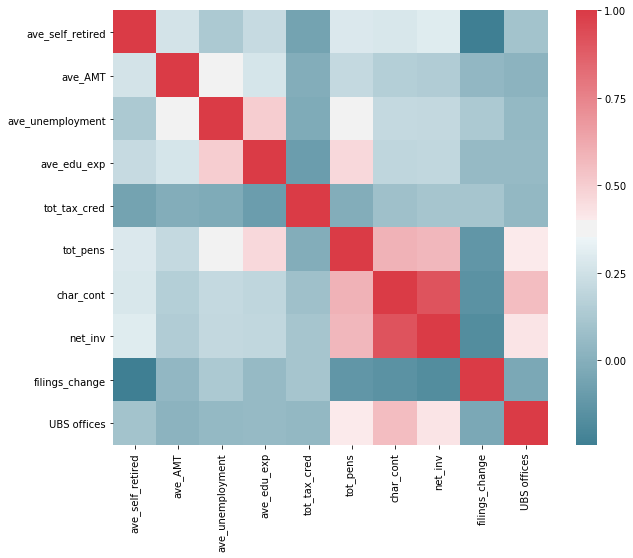

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [30]:
corr = data.corr()
corr.style.background_gradient().set_precision(2)

,ave_self_retired,ave_AMT,ave_unemployment,ave_edu_exp,tot_tax_cred,tot_pens,char_cont,net_inv,filings_change,UBS offices
ave_self_retired,1,0.26,0.13,0.22,-0.059,0.29,0.28,0.3,-0.24,0.098
ave_AMT,0.26,1,0.36,0.27,-0.0073,0.21,0.16,0.15,0.039,0.023
ave_unemployment,0.13,0.36,1,0.5,-0.021,0.39,0.21,0.21,0.13,0.05
ave_edu_exp,0.22,0.27,0.5,1,-0.091,0.46,0.2,0.2,0.055,0.058
tot_tax_cred,-0.059,-0.0073,-0.021,-0.091,1,-0.006,0.084,0.11,0.11,0.047
tot_pens,0.29,0.21,0.39,0.46,-0.006,1,0.6,0.57,-0.13,0.4
char_cont,0.28,0.16,0.21,0.2,0.084,0.6,1,0.92,-0.14,0.55
net_inv,0.3,0.15,0.21,0.2,0.11,0.57,0.92,1,-0.17,0.42
filings_change,-0.24,0.039,0.13,0.055,0.11,-0.13,-0.14,-0.17,1,-0.036
UBS offices,0.098,0.023,0.05,0.058,0.047,0.4,0.55,0.42,-0.036,1


In [31]:
# high weight samples
hw_data = data[data['UBS offices'] > 1]

In [32]:
# low weight samples
lw_data = data[data['UBS offices'] == 1]

In [33]:
# randomly split the low weight samples into train and test set
X_train, X_test = train_test_split(lw_data, test_size=0.30, random_state=42)

In [34]:
# add high weight samples to training data
X_train = X_train.append(hw_data)

In [35]:
# drop UBS offices column
X_test = X_test.drop(['UBS offices'], axis=1)

In [36]:
# create 10-fold for cross validation
kf = KFold(n_splits=10)

# One-Class SVM

In [42]:
# kernel can be linear, rbf, poly, sigmoid
ocsvm = svm.OneClassSVM(nu=0.001, kernel='sigmoid', gamma='auto')

In [43]:
# arrays to store model performance
train_ocsvm = []
cv_ocsvm = []
test_ocsvm = []

# split training set into 10 part, each time the model is trained on 9 parts and cross validated on the remaining part
for k, (train_index, test_index) in enumerate(kf.split(X_train)):
    X, X_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    # sample weights
    sample_weights = X['UBS offices']
    # drop UBS offices column
    X = X.drop(['UBS offices'], axis=1)
    X_cv = X_cv.drop(['UBS offices'], axis=1)
    # scale to mean=0 and stdev=1 based on training set
    scaler = preprocessing.StandardScaler().fit(X)
    # apply scaling function on train, cross validation, and test set
    X_train_n = scaler.transform(X)
    X_cv_norm = scaler.transform(X_cv)
    X_test_norm = scaler.transform(X_test)
    # Demo model's sensitivity: modify weights
    #X['tot_inc'] = X.apply(lambda row: row.tot_inc * 2.0, axis=1)
    # fit classifier on train set
    ocsvm.fit(X_train_n, sample_weight = sample_weights)
    # prediction on train set, cross validation, and test set (either 1 or -1)
    y_train = ocsvm.predict(X_train_n)
    y_cv = ocsvm.predict(X_cv_norm)
    y_test = ocsvm.predict(X_test_norm)
    # count the number of wrong classifications
    train_error = y_train[y_train == -1].size
    cv_error = y_cv[y_cv == -1].size
    test_error = y_test[y_test == -1].size
    # model accuracy
    train_accuracy = 1 - train_error / y_train.size
    cv_accuracy = 1 - cv_error / y_cv.size
    test_accuracy = 1 - test_error / y_test.size
    # print
    train_ocsvm.append(train_accuracy)
    cv_ocsvm.append(cv_accuracy)
    test_ocsvm.append(test_accuracy)
    print("[fold {0}] train: {1:.2f}, cv: {2:.2f}, test: {3:.2f}".
          format(k, 100 * train_accuracy, 100 * cv_accuracy, 100 * test_accuracy))

[fold 0] train: 98.91, cv: 100.00, test: 98.73
[fold 1] train: 98.91, cv: 100.00, test: 100.00
[fold 2] train: 99.45, cv: 100.00, test: 100.00
[fold 3] train: 98.91, cv: 100.00, test: 100.00
[fold 4] train: 98.91, cv: 100.00, test: 98.73
[fold 5] train: 98.91, cv: 95.00, test: 100.00
[fold 6] train: 98.91, cv: 100.00, test: 100.00
[fold 7] train: 98.91, cv: 100.00, test: 100.00
[fold 8] train: 98.91, cv: 100.00, test: 100.00
[fold 9] train: 97.83, cv: 90.00, test: 97.47


The mean score and the 95% confidence interval of the score estimate are hence given by:

In [44]:
print("Train accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(train_ocsvm).mean(), 100 * np.asarray(train_ocsvm).std() * 2))

Train accuracy: 98.86 (+/- 0.76)


In [45]:
print("CV accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(cv_ocsvm).mean(), 100 * np.asarray(cv_ocsvm).std() * 2))

CV accuracy: 98.50 (+/- 6.40)


In [46]:
print("Test accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(test_ocsvm).mean(), 100 * np.asarray(test_ocsvm).std() * 2))

Test accuracy: 99.49 (+/- 1.68)


# Isolation Forest

In [42]:
# create a model caller
iso_f = IsolationForest(n_estimators=100,random_state=42, contamination=0.000, behaviour='new')

In [43]:
# arrays to store model performance
train_isof = []
cv_isof = []
test_isof = []

# split training set into 10 part, each time the model is trained on 9 parts and cross validated on the remaining part
for k, (train_index, test_index) in enumerate(kf.split(X_train)):
    X, X_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    # sample weights
    sample_weights = X['UBS offices']
    # drop UBS offices column
    X = X.drop(['UBS offices'], axis=1)
    X_cv = X_cv.drop(['UBS offices'], axis=1)
    # Demo model's sensitivity: modify weights
    #X['tot_inc'] = X.apply(lambda row: row.tot_inc * 2.0, axis=1)
    # fit classifier on train set
    iso_f.fit(X, sample_weight = sample_weights)
    # prediction on train set, cross validation, and test set (either 1 or -1)
    y_pred_train = iso_f.predict(X)
    y_pred_cv = iso_f.predict(X_cv)
    y_pred_test = iso_f.predict(X_test)
    # count the number of wrong classifications
    train_error = y_pred_train[y_pred_train == -1].size
    cv_error = y_pred_cv[y_pred_cv == -1].size
    test_error = y_pred_test[y_pred_test == -1].size
    # model accuracy
    train_accuracy = 1 - train_error / y_pred_train.size
    cv_accuracy = 1 - cv_error / y_pred_cv.size
    test_accuracy = 1 - test_error / y_pred_test.size
    # print
    train_isof.append(train_accuracy)
    cv_isof.append(cv_accuracy)
    test_isof.append(test_accuracy)
    print("[fold {0}] train: {1:.2f}, cv: {2:.2f}, test: {3:.2f}".
          format(k, 100 * train_accuracy, 100 * cv_accuracy, 100 * test_accuracy))

[fold 0] train: 100.00, cv: 100.00, test: 100.00
[fold 1] train: 100.00, cv: 100.00, test: 100.00
[fold 2] train: 100.00, cv: 100.00, test: 100.00
[fold 3] train: 100.00, cv: 100.00, test: 100.00
[fold 4] train: 100.00, cv: 100.00, test: 100.00
[fold 5] train: 100.00, cv: 100.00, test: 100.00
[fold 6] train: 100.00, cv: 100.00, test: 100.00
[fold 7] train: 100.00, cv: 100.00, test: 100.00
[fold 8] train: 100.00, cv: 100.00, test: 100.00
[fold 9] train: 100.00, cv: 95.00, test: 100.00


The mean score and the 95% confidence interval of the score estimate are hence given by:

In [44]:
print("Train accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(train_isof).mean(), 100 * np.asarray(train_isof).std() * 2))

Train accuracy: 100.00 (+/- 0.00)


In [45]:
print("CV accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(cv_isof).mean(), 100 * np.asarray(cv_isof).std() * 2))

CV accuracy: 99.50 (+/- 3.00)


In [46]:
print("Test accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(test_isof).mean(), 100 * np.asarray(test_isof).std() * 2))

Test accuracy: 100.00 (+/- 0.00)


In [47]:
# first tree
dt = iso_f.estimators_[0]
print(dt)

ExtraTreeRegressor(criterion='mse', max_depth=8, max_features=1,
          max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=1952926171,
          splitter='random')


In [48]:
# save first tree structure
# tree.export_graphviz(dt, out_file='dtree.dot', feature_names=X.columns, class_names=True, filled=True)

In [49]:
# save as image
'''
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Thang/Anaconda3/Library/bin/graphviz/'

graph = Source( tree.export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=True, filled=True))
png_bytes = graph.pipe(format='png')
with open('dtree.png','wb') as f:
    f.write(png_bytes)
'''
# from IPython.display import Image
# Image(png_bytes)

'\nimport os\nos.environ["PATH"] += os.pathsep + \'C:/Users/Thang/Anaconda3/Library/bin/graphviz/\'\n\ngraph = Source( tree.export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=True, filled=True))\npng_bytes = graph.pipe(format=\'png\')\nwith open(\'dtree.png\',\'wb\') as f:\n    f.write(png_bytes)\n'

In [50]:
# display in Jupyter Notebook
'''
graph = Source( tree.export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=True, filled=True))
SVG(graph.pipe(format='svg'))
'''

"\ngraph = Source( tree.export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=True, filled=True))\nSVG(graph.pipe(format='svg'))\n"

# Local Outlier Factor

In [51]:
# metric can be cityblock, cosine, euclidean, l1’, l2, manhattan
lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination= 0.001, metric='euclidean')

In [52]:
# arrays to store model performance
cv_lof = []
test_lof = []

# split training set into 10 part, each time the model is trained on 9 parts and cross validated on the remaining part
for k, (train_index, test_index) in enumerate(kf.split(X_train)):
    X, X_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    # drop UBS offices column
    X = X.drop(['UBS offices'], axis=1)
    X_cv = X_cv.drop(['UBS offices'], axis=1)
    # scale to mean=0 and stdev=1 based on training set
    scaler = preprocessing.StandardScaler().fit(X)
    # apply scaling function on train, cross validation, and test set
    X_train_n = scaler.transform(X)
    X_cv_norm = scaler.transform(X_cv)
    X_test_norm = scaler.transform(X_test)
    # Demo model's sensitivity: modify weights
    #X['tot_inc'] = X.apply(lambda row: row.tot_inc * 2.0, axis=1)
    # fit classifier on train set
    lof.fit(X_train_n)
    # prediction on cross validation and test set (either 1 or -1)
    y_cv = lof.predict(X_cv_norm)
    y_test = lof.predict(X_test_norm)
    # count the number of wrong classifications
    cv_error = y_cv[y_cv == -1].size
    test_error = y_test[y_test == -1].size
    # model accuracy
    cv_accuracy = 1 - cv_error / y_cv.size
    test_accuracy = 1 - test_error / y_test.size
    # print
    cv_lof.append(cv_accuracy)
    test_lof.append(test_accuracy)
    print("[fold {0}] cv: {1:.2f}, test: {2:.2f}".
          format(k, 100 * cv_accuracy, 100 * test_accuracy))

[fold 0] cv: 100.00, test: 100.00
[fold 1] cv: 100.00, test: 100.00
[fold 2] cv: 100.00, test: 100.00
[fold 3] cv: 100.00, test: 100.00
[fold 4] cv: 95.00, test: 100.00
[fold 5] cv: 100.00, test: 100.00
[fold 6] cv: 100.00, test: 100.00
[fold 7] cv: 95.00, test: 100.00
[fold 8] cv: 100.00, test: 100.00
[fold 9] cv: 95.00, test: 100.00


The mean score and the 95% confidence interval of the score estimate are hence given by:

In [53]:
print("CV accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(cv_lof).mean(), 100 * np.asarray(cv_lof).std() * 2))

CV accuracy: 98.50 (+/- 4.58)


In [54]:
print("Test accuracy: %0.2f (+/- %0.2f)" % (100 * np.asarray(test_lof).mean(), 100 * np.asarray(test_lof).std() * 2))

Test accuracy: 100.00 (+/- 0.00)


# Prediction

In [55]:
# create list of Zip codes that do not have UBS office
prediction_set = df[~df.zipcode.isin(branch['Zip'])]

In [56]:
# load zipcode csv
zip_to_city = pd.read_csv("zip_code_database.csv")

In [57]:
zip_to_city = zip_to_city[['zip', 'primary_city']]

In [58]:
# join the two tables on zip code
prediction_matrix = prediction_set.join(zip_to_city.set_index('zip'), on='zipcode')

In [59]:
# merge City and State columns to create Location
# cross_check = prediction_matrix
# cross_check['Location'] = cross_check.apply (lambda row: row.primary_city + ", " + row.STATE,axis=1)

In [60]:
# cross_check = cross_check.drop(['primary_city'], axis=1)

In [61]:
# get a list of columns
# cols = list(cross_check)

# move the column to head of list using index, pop and insert
# cols.insert(0, cols.pop(cols.index('Location')))

# use loc to reorder
# cross_check = cross_check.loc[:, cols]

# save to csv
# cross_check.to_csv('cross_check.csv', index=False)

In [62]:
# drop irrelevant columns
prediction_matrix = prediction_matrix.drop(['zipcode', 'STATEFIPS', 'agi_stub'], axis=1)

In [63]:
# merge City and State columns to create Location
prediction_matrix['Location'] = prediction_matrix.apply (lambda row: row.primary_city + ", " + row.STATE,axis=1)

In [64]:
# get a list of columns
cols = list(prediction_matrix)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Location')))

# use loc to reorder
prediction_matrix = prediction_matrix.loc[:, cols]

In [65]:
# drop extra columns
prediction_matrix = prediction_matrix.drop(['primary_city', 'STATE'], axis=1)

In [66]:
# group by Location and sum the stats
group_predict = prediction_matrix.groupby('Location', as_index=False).sum()

In [67]:
# save to csv
# group_predict.to_csv('prediction_set.csv', index=False)

In [68]:
# exclude Location that has 0 stats
group_predict = group_predict[group_predict['N1'] != 0]
group_predict = group_predict[group_predict['N1_2012'] != 0]

In [69]:
# create new columns
group_predict['ave_AGI'] = group_predict.apply (lambda row: ave_AGI (row),axis=1)
group_predict['ave_div'] = group_predict.apply (lambda row: ave_div (row),axis=1)
group_predict['ave_pro_income'] = group_predict.apply (lambda row: ave_pro_income (row),axis=1)
group_predict['ave_self_retired'] = group_predict.apply (lambda row: ave_self_retired (row),axis=1)
group_predict['ave_item_deduct'] = group_predict.apply (lambda row: ave_item_deduct (row),axis=1)
group_predict['ave_RET'] = group_predict.apply (lambda row: ave_RET (row),axis=1)
group_predict['ave_AMT'] = group_predict.apply (lambda row: ave_AMT (row),axis=1)
group_predict['ave_EIC'] = group_predict.apply (lambda row: ave_EIC (row),axis=1)
group_predict['ave_unemployment'] = group_predict.apply (lambda row: ave_unemployment (row),axis=1)
group_predict['ave_edu_exp'] = group_predict.apply (lambda row: ave_edu_exp (row),axis=1)

group_predict['tot_tax_cred'] = group_predict.apply (lambda row: tot_tax_cred (row),axis=1)
group_predict['tot_inc'] = group_predict.apply (lambda row: tot_inc (row),axis=1)
group_predict['tot_pens'] = group_predict.apply (lambda row: tot_pens (row),axis=1)
group_predict['char_cont'] = group_predict.apply (lambda row: char_cont (row),axis=1)
group_predict['net_inv'] = group_predict.apply (lambda row: net_inv (row),axis=1)
group_predict['filings_change'] = group_predict.apply (lambda row: filings_change (row),axis=1)

In [70]:
group_predict = group_predict.reset_index(drop=True)

In [71]:
attr_list = np.array(list(data))

In [72]:
# create new working table that only uses the selected features
private_set = group_predict[attr_list[attr_list != 'UBS offices']]

# Results from One-Class SVM

In [73]:
# scale to mean=0 and stdev=1 based on training set
scaler = preprocessing.StandardScaler().fit(X)

# apply scaling function on prediction set
X_predict = scaler.transform(private_set)

# prediction on prediction set (either 1 or -1)
ocsvm_prediction = ocsvm.predict(X_predict)

C:\Users\Thang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [74]:
# Signed distance to the separating hyperplane (positive for an inlier and negative for an outlier)
result = ocsvm.decision_function(X_predict)

In [75]:
# sort from largest to smallest distance
ocsvm_array = sorted(result, reverse=True)

In [76]:
# top 10
ocsvm_pred = ocsvm_array[0:10]
ocsvm_pred

[0.089978158330085184,
 0.083098549925289311,
 0.079899024949144914,
 0.079182132575028069,
 0.079088110636175851,
 0.078440893106927312,
 0.078001646184677739,
 0.076718709500753587,
 0.076035571737902333,
 0.075947138507631934]

In [77]:
# look up the index of matching distance in the original result array
city_index = []

for idx in ocsvm_pred:
    item_index = np.where(result == idx)
    for l in item_index:
        city_index.extend(l)

In [78]:
# look up Location based on above indices
ocsvm_res = []

for res in city_index:
    ocsvm_res.append(group_predict['Location'][res])
    print(group_predict['Location'][res])

Greenbrae, CA
Orinda, CA
Cypress, TX
Lafayette, CA
Los Gatos, CA
Belvedere Tiburon, CA
Needham, MA
Livingston, NJ
Morristown, NJ
Wayland, MA


# Results from Isolation Forest

In [79]:
# prediction on prediction set (either 1 or -1)
isof_prediction = iso_f.predict(private_set)

In [80]:
# Average anomaly score of X of the base classifiers (higher for normal, lower for outlier)
isof_result = iso_f.decision_function(private_set)

In [81]:
# sort from largest to smallest distance
isof_array = sorted(isof_result, reverse=True)

In [82]:
# top 10
isof_pred = isof_array[0:10]
isof_pred

[0.31335296473985946,
 0.31323874805305968,
 0.31239934058451674,
 0.31215198256740778,
 0.31202337582483775,
 0.31185031786055223,
 0.31168398317128582,
 0.3114266864486766,
 0.31123625704451519,
 0.31116906099982433]

In [83]:
# look up the index of matching distance in the original result array
isof_city_index =[]

for idx in isof_pred:
    item_index = np.where(isof_result == idx)
    for l in item_index:
        isof_city_index.extend(l)

In [84]:
# look up Location based on above indices
iso_f_res = []

for res in isof_city_index:
    iso_f_res.append(group_predict['Location'][res])
    print(group_predict['Location'][res])

Owensboro, KY
Dallas, PA
Effingham, IL
Michigan City, IN
Keene, NH
Versailles, KY
Newark, OH
Wooster, OH
Greenwood, SC
Kent, OH


# Results from Local Outlier Factor

In [85]:
# scale to mean=0 and stdev=1 based on training set
scaler = preprocessing.StandardScaler().fit(X)

# apply scaling function on prediction set
X_predict = scaler.transform(private_set)

# prediction on prediction set (either 1 or -1)
lof_prediction = lof.predict(X_predict)

C:\Users\Thang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [86]:
# Bigger is better, i.e. large values correspond to inliers.
lof_result = lof.decision_function(X_predict)

In [87]:
# sort from largest to smallest distance
lof_array = sorted(lof_result, reverse=True)

In [88]:
# top 10
lof_pred = lof_array[0:10]
lof_pred

[2.8986296584743361,
 2.8944276907465509,
 2.8939795814084124,
 2.8936506268797206,
 2.8932417662771499,
 2.8929469353938617,
 2.8927409801135,
 2.8921071293491742,
 2.8904987683356431,
 2.886803872734514]

In [89]:
lof_city_index =[]

for idx in lof_pred:
    item_index = np.where(lof_result == idx)
    for l in item_index:
        lof_city_index.extend(l)

In [90]:
lof_res = []

for res in lof_city_index:
    lof_res.append(group_predict['Location'][res])
    print(group_predict['Location'][res])

Jasper, IN
Tucker, GA
Troy, OH
Michigan City, IN
Elkhart, IN
Maumelle, AR
Greenfield, IN
Belvidere, IL
West Springfield, MA
Springfield, OH


# Combined results

In [118]:
combined_results = np.array([result, isof_result, lof_result])

In [119]:
combined_results_df = pd.DataFrame({'OCSVM':combined_results[0,:],'ISOF':combined_results[1,:], 'LOF':combined_results[2,:]})

In [108]:
combined_results_df1 = combined_results_df[combined_results_df['OCSVM'] > 0]

In [109]:
combined_results_df2 = combined_results_df1[combined_results_df1['ISOF'] > 0]

In [110]:
combined_results_df3 = combined_results_df2[combined_results_df2['LOF'] > 0]

In [127]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, len(combined_results_df3))).fit(combined_results_df3)
combined_results_df_n = pd.DataFrame(scaler.transform(combined_results_df3), columns = combined_results_df3.columns, index = combined_results_df3.index)

In [128]:
combined_results_df_n['combined'] = combined_results_df_n.apply (lambda row: row.OCSVM + row.ISOF + row.LOF,axis=1)

In [129]:
combined_array = sorted(combined_results_df_n['combined'], reverse=True)

In [130]:
combined_pred = combined_array[0:10]

In [131]:
combined_pred

[21659.97512046315,
 21601.531867340575,
 21494.223869463156,
 21456.955003792071,
 21392.06261463261,
 21315.026164613471,
 21310.100119558148,
 21266.609325518377,
 21252.544419672955,
 21248.98747773208]

In [132]:
comb_index =[]

for rank in combined_pred:
    idx = combined_results_df_n[combined_results_df_n['combined'] == rank].index.tolist()
    comb_index.extend(idx)

In [133]:
comb_res = []

for res in comb_index:
    comb_res.append(group_predict['Location'][res])
    print(group_predict['Location'][res])

Morristown, NJ
Glen Ellyn, IL
Doylestown, PA
Lake Zurich, IL
Andover, MA
Fairfield, CT
Libertyville, IL
Ambler, PA
Newport Beach, CA
Wheaton, IL


# Cross checking

In [100]:
# load IRS csv
# cc = pd.read_csv("cross_check.csv")

In [101]:
# Cross check statistics from OCSVM results
# cc_ocsvm = cc[cc['Location'].isin(ocsvm_res)]
# cc_ocsvm

In [102]:
# Cross check statistics from Isolation Forest results
# cc_isof = cc[cc['Location'].isin(iso_f_res)]
# cc_isof

In [103]:
# Cross check statistics from Local Outlier Factor results
# cc_lof = cc[cc['Location'].isin(lof_res)]
# cc_lof

In [104]:
# Cross check statistics from Combined results
# cc_comb = cc[cc['Location'].isin(comb_res)]
# cc_comb

In [105]:
# cc_ocsvm.to_csv('cc_ocsvm.csv', index=False)
# cc_isof.to_csv('cc_isof.csv', index=False)
# cc_lof.to_csv('cc_lof.csv', index=False)
# cc_comb.to_csv('cc_comb.csv', index=False)